1) Setup and Data Loading

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Set plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

#Define the file path (Assuming 'bank_marketing_cleaned_unscaled.csv' is uploaded to Colab's file session)
file_path = "bank_marketing_cleaned_unscaled.csv"

#Load the dataset
print("1) Data Loading and Initial Inspection")
df = pd.read_csv(file_path)

#Print first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

#Print column information
print("\nDataset Information (Data Types and Non-Null Counts):")
df.info()

#Define feature groups for subsequent analysis
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                  'euribor3m', 'nr.employed']
target_col = 'y'

1) Data Loading and Initial Inspection

First 5 rows of the dataset:
| age   | duration   | campaign   | pdays   | previous   | emp.var.rate   | cons.price.idx   | cons.conf.idx   | euribor3m   | nr.employed   | y   | job_blue-collar   | job_entrepreneur   | job_housemaid   | job_management   | job_retired   | job_self-employed   | job_services   | job_student   | job_technician   | job_unemployed   | marital_married   | marital_single   | education_basic.6y   | education_basic.9y   | education_high.school   | education_illiterate   | education_professional.course   | education_university.degree   | default_unknown   | default_yes   | housing_yes   | loan_yes   | contact_telephone   | month_aug   | month_dec   | month_jul   | month_jun   | month_mar   | month_may   | month_nov   | month_oct   | month_sep   | day_of_week_mon   | day_of_week_thu   | day_of_week_tue   | day_of_week_wed   | poutcome_nonexistent   | poutcome_success   |
|:------|:-----------|:-----------|:--------|:--------

INSIGHT: All columns are non-null and correctly typed. The presence of many boolean columns confirms one-hot encoding is complete.

2) Target Variable Analysis: 'y' (Propensity to Subscribe)


2) Target Variable Analysis

Target Variable 'y' Distribution (Term Deposit Subscription):
| y   | proportion   |
|:----|:-------------|
| 0   | 88.73        |
| 1   | 11.27        |


/tmp/ipython-input-1629830934.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette="viridis")


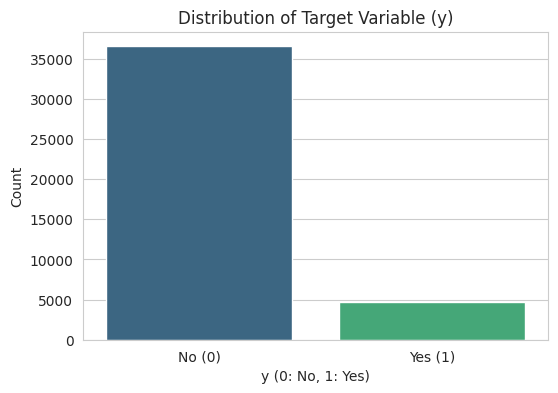

In [7]:
print("\n2) Target Variable Analysis")
target_counts = df[target_col].value_counts()
target_proportions = df[target_col].value_counts(normalize=True) * 100

print("\nTarget Variable 'y' Distribution (Term Deposit Subscription):")
print(target_proportions.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

#Plot the target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df, palette="viridis")
plt.title('Distribution of Target Variable (y)')
plt.xlabel('y (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.savefig('target_distribution.png')
plt.show()

INSIGHT: The class distribution is highly imbalanced (typically ~89% No vs. ~11% Yes). This requires evaluation metrics like ROC-AUC over simple accuracy.

3) Numerical Feature Analysis


3) Numerical Feature Analysis

Descriptive Statistics for Numerical Features:
|                |    count |    mean |    std |     min |     25% |     50% |     75% |     max |
|:---------------|---------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|
| age            | 41188.00 |   40.02 |  10.42 |   17.00 |   32.00 |   38.00 |   47.00 |   98.00 |
| duration       | 41188.00 |  258.29 | 259.28 |    0.00 |  102.00 |  180.00 |  319.00 | 4918.00 |
| campaign       | 41188.00 |    2.57 |   2.77 |    1.00 |    1.00 |    2.00 |    3.00 |   56.00 |
| pdays          | 41188.00 |  962.48 | 186.91 |    0.00 |  999.00 |  999.00 |  999.00 |  999.00 |
| previous       | 41188.00 |    0.17 |   0.49 |    0.00 |    0.00 |    0.00 |    0.00 |    7.00 |
| emp.var.rate   | 41188.00 |    0.08 |   1.57 |   -3.40 |   -1.80 |    1.10 |    1.40 |    1.40 |
| cons.price.idx | 41188.00 |   93.58 |   0.58 |   92.20 |   93.08 |   93.75 |   93.99 |   94.77 |
| cons.conf.idx  | 41188.00 | 

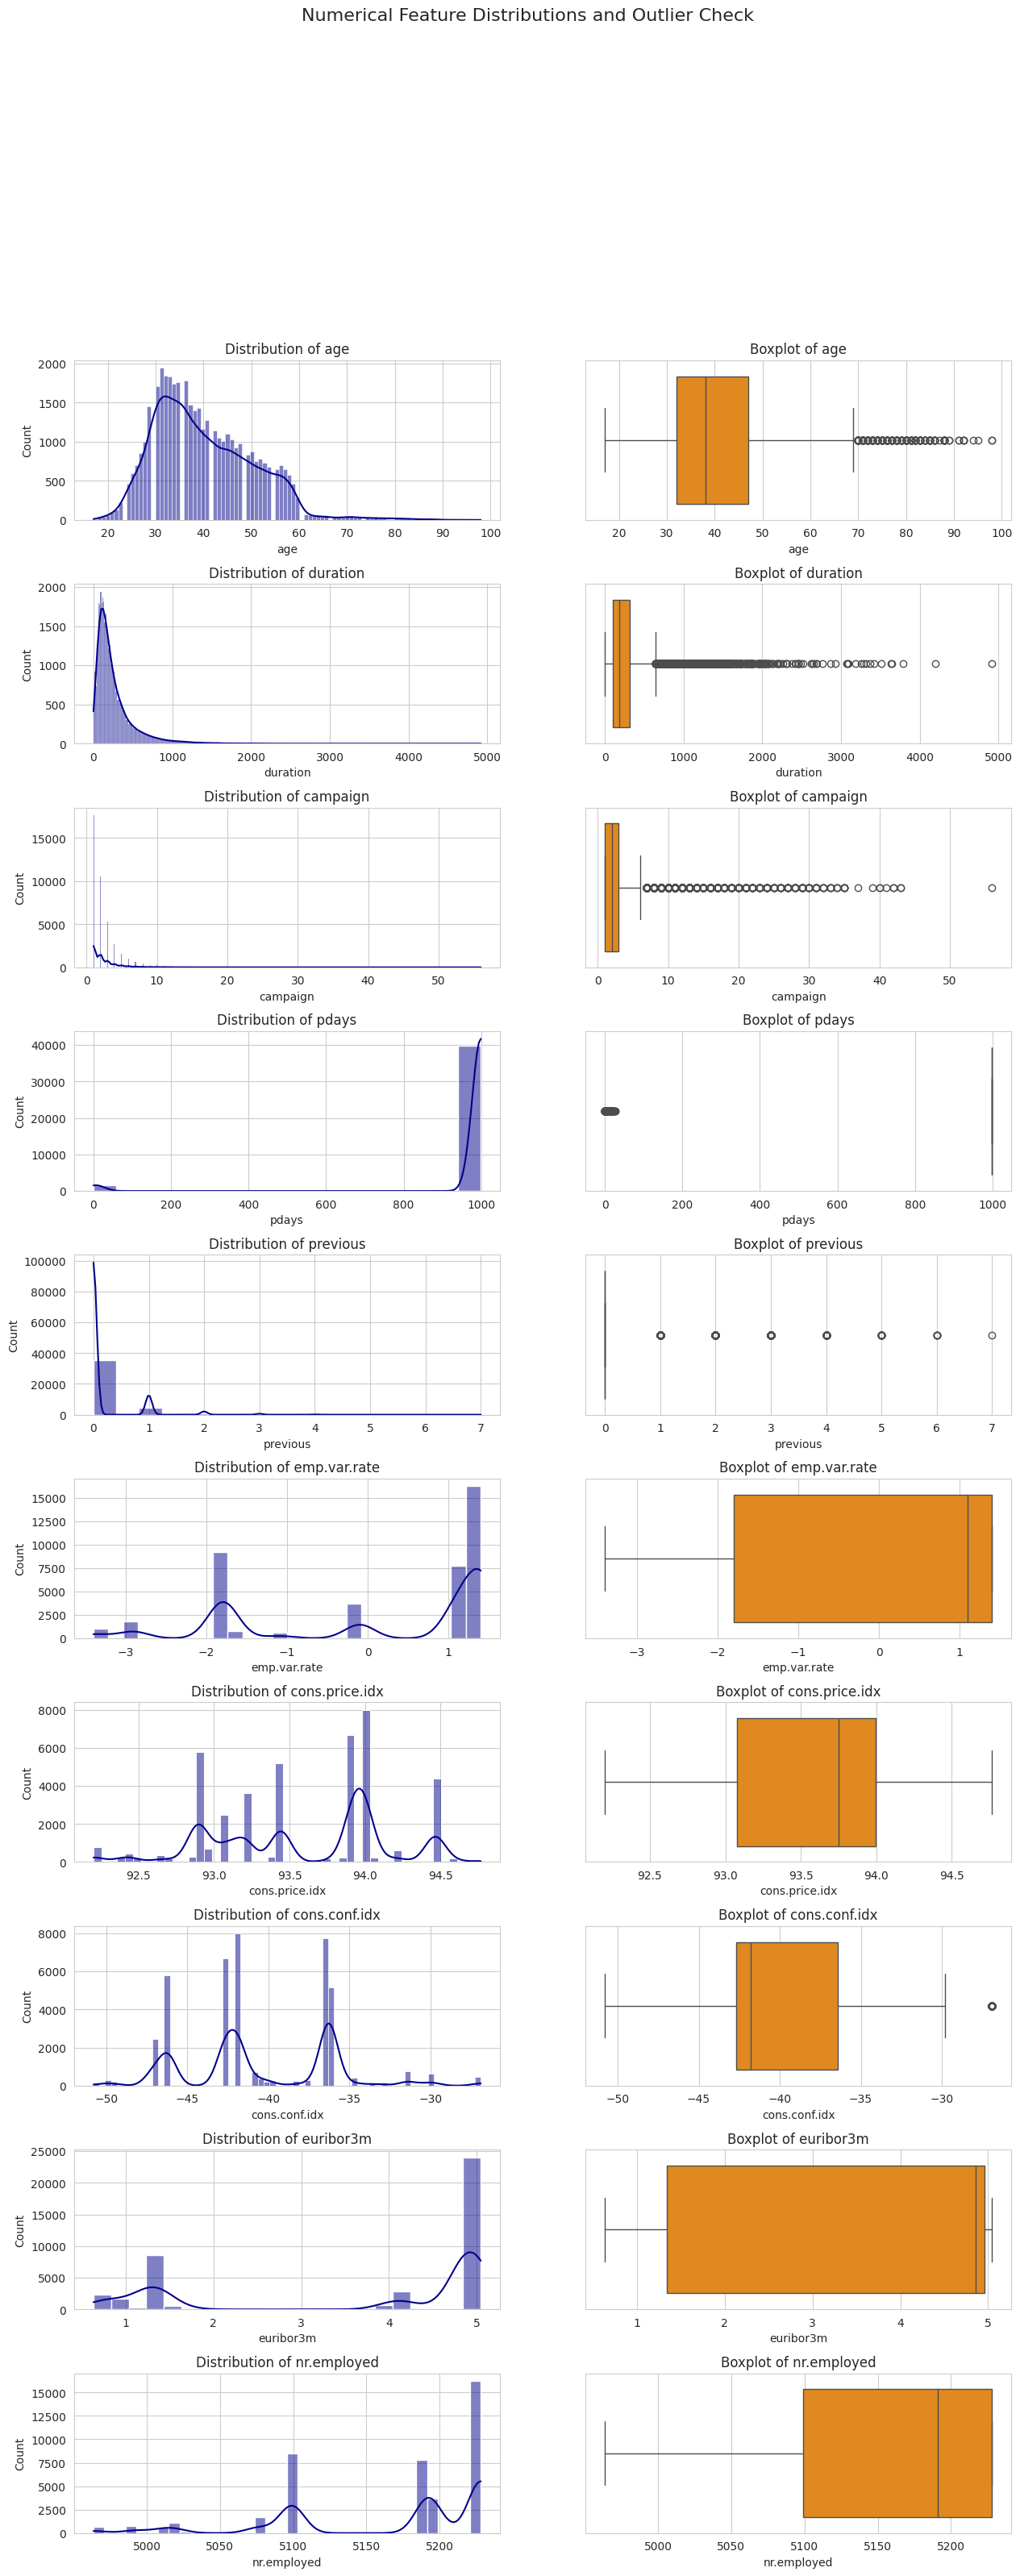

In [8]:
print("\n3) Numerical Feature Analysis")
print("\nDescriptive Statistics for Numerical Features:")
print(df[numerical_cols].describe().T.to_markdown(floatfmt=".2f"))

#Plot distributions (Histograms and Boxplots)
print("\nGenerating Histograms and Boxplots for numerical features...")
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(15, 3.5 * len(numerical_cols)))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numerical_cols):
    #Histogram
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color='darkblue')
    axes[i, 0].set_title(f'Distribution of {col}', fontsize=12)

    #Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1], color='darkorange')
    axes[i, 1].set_title(f'Boxplot of {col}', fontsize=12)

plt.suptitle('Numerical Feature Distributions and Outlier Check', y=1.005, fontsize=16)
plt.savefig('numerical_feature_distributions.png', bbox_inches='tight')
plt.show()

INSIGHTS:
'duration' is highly skewed and should be handled carefully for potential data leakage (it's unknown before the call).

'pdays' has a max of 999, which is a sentinel value for 'not contacted'. It should be converted to a binary flag and a numeric days column for those who were contacted.

'campaign' is skewed right, indicating a few customers were contacted many times (potential outliers).

4) Categorical Feature Analysis and Propensity Rate


4) Categorical Feature Analysis and Propensity Rate

JOB Conversion Rates (Top 5 for job):
|            |      0 |
|:-----------|-------:|
| student    | 0.3143 |
| retired    | 0.2523 |
| unemployed | 0.1420 |
| management | 0.1122 |
| technician | 0.1083 |


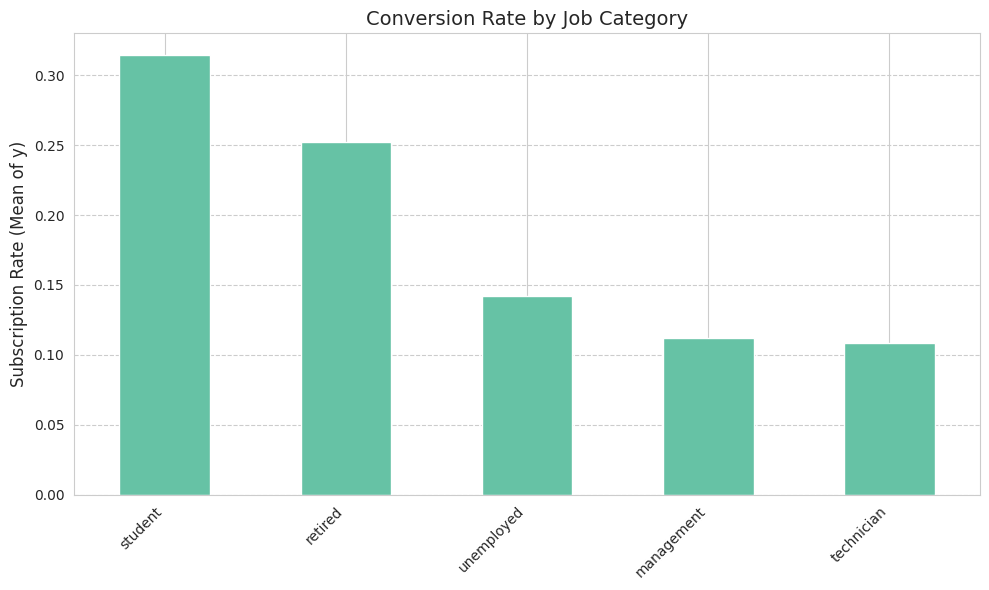


MARITAL Conversion Rates (Top 5 for marital):
|         |      0 |
|:--------|-------:|
| single  | 0.1400 |
| married | 0.1017 |


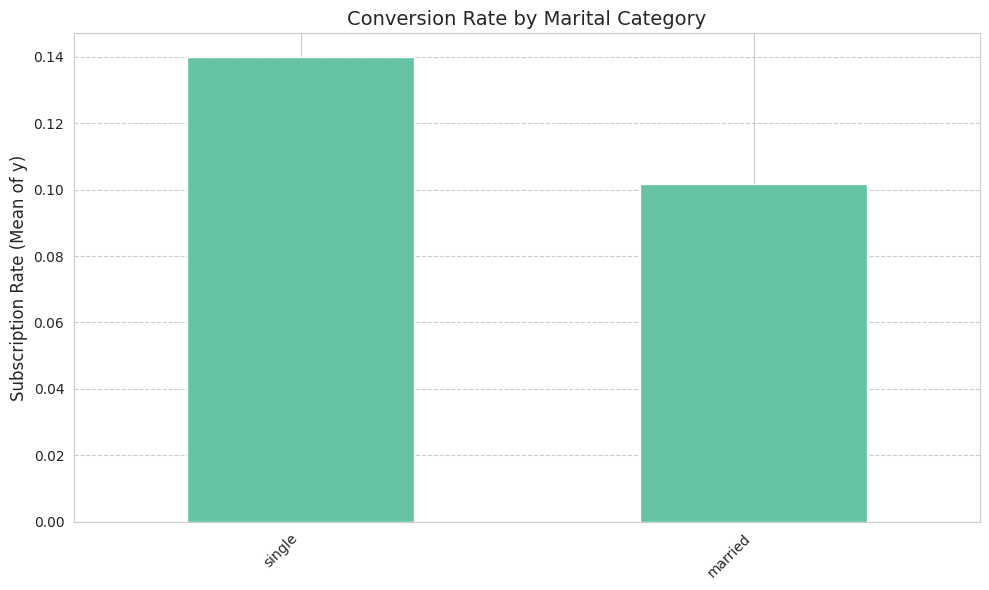


EDUCATION Conversion Rates (Top 5 for education):
|                     |      0 |
|:--------------------|-------:|
| illiterate          | 0.2222 |
| university.degree   | 0.1382 |
| professional.course | 0.1135 |
| high.school         | 0.1084 |
| basic.6y            | 0.0820 |


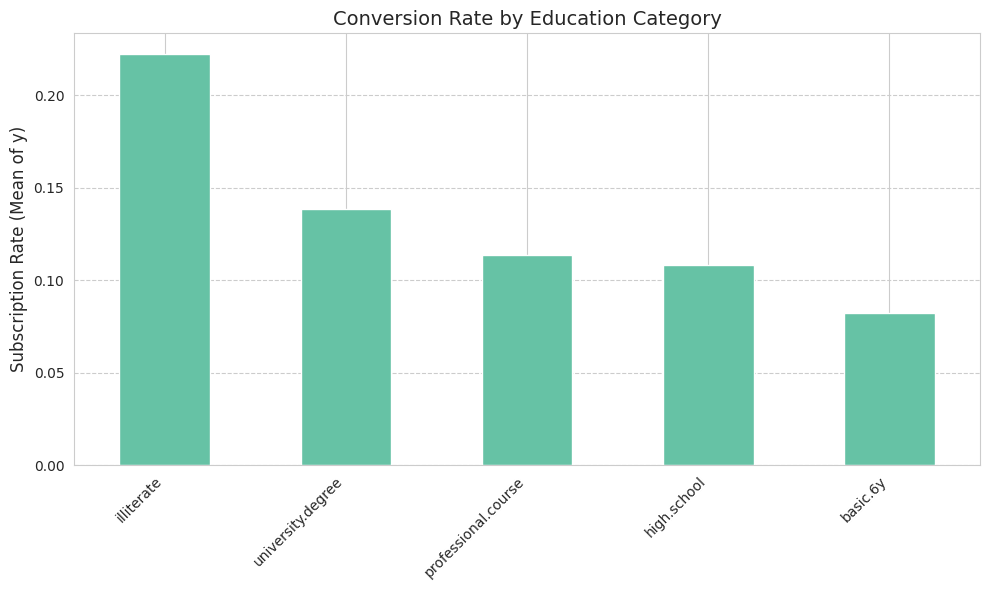


DEFAULT Conversion Rates (Top 5 for default):
|         |      0 |
|:--------|-------:|
| unknown | 0.0515 |
| yes     | 0.0000 |


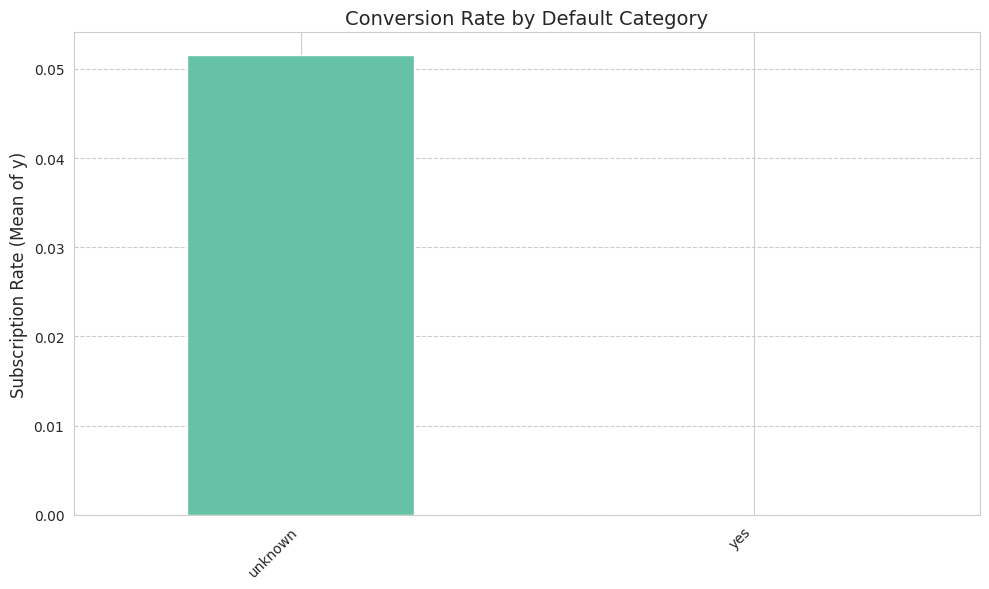


HOUSING Conversion Rates (Top 5 for housing):
|     |      0 |
|:----|-------:|
| yes | 0.1158 |


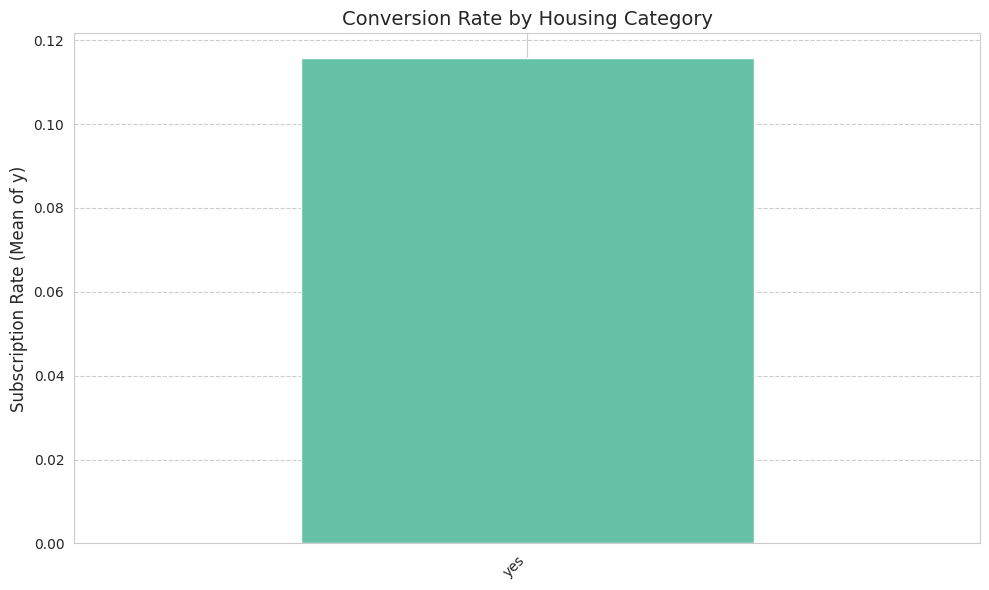


LOAN Conversion Rates (Top 5 for loan):
|     |      0 |
|:----|-------:|
| yes | 0.1093 |


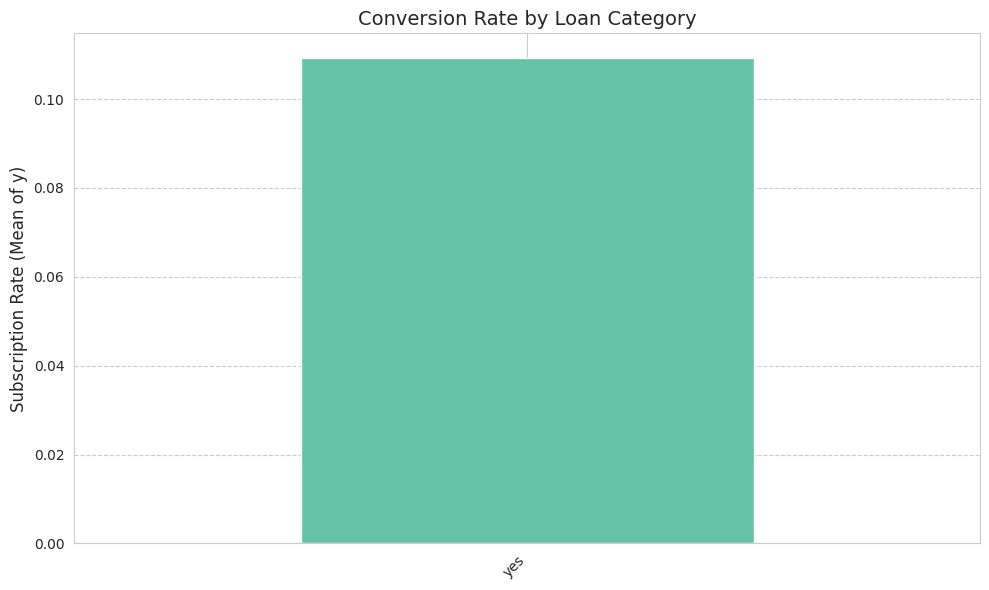


CONTACT Conversion Rates (Top 5 for contact):
|           |      0 |
|:----------|-------:|
| telephone | 0.0523 |


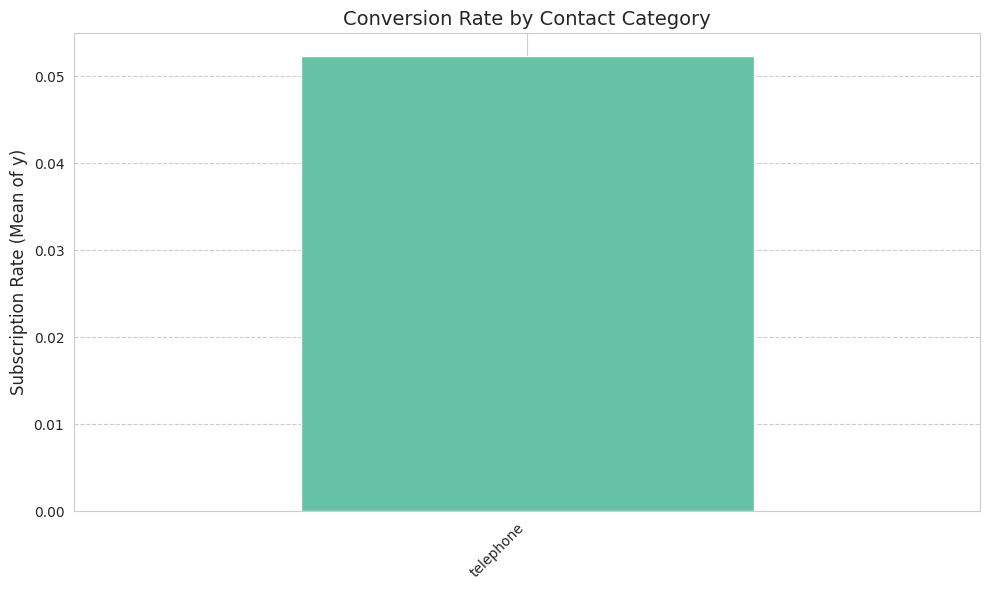


MONTH Conversion Rates (Top 5 for month):
|     |      0 |
|:----|-------:|
| mar | 0.5055 |
| dec | 0.4890 |
| sep | 0.4491 |
| oct | 0.4387 |
| aug | 0.1060 |


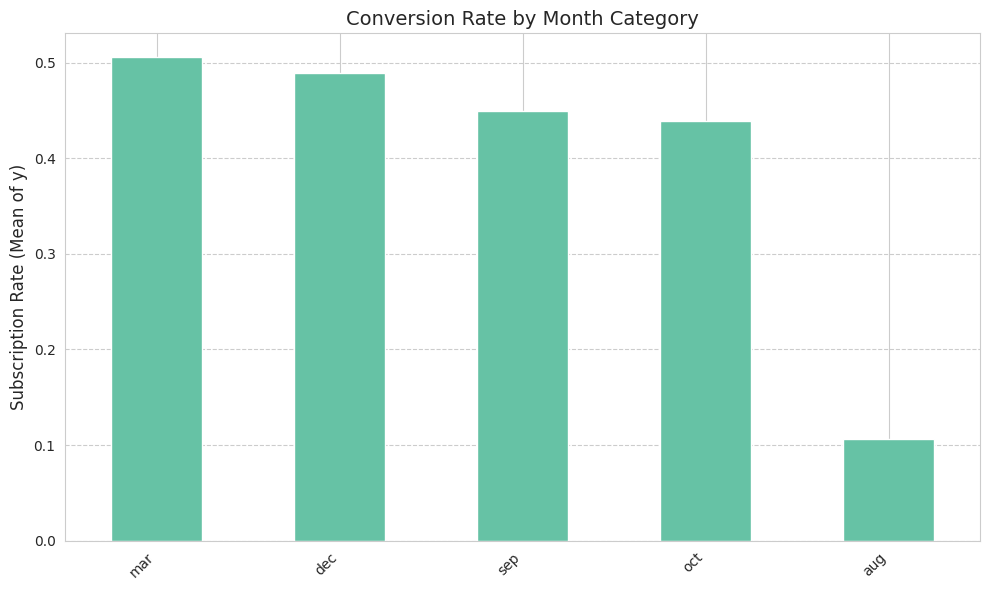


DAY Conversion Rates (Top 5 for day):
|             |      0 |
|:------------|-------:|
| of_week_thu | 0.1212 |
| of_week_tue | 0.1178 |
| of_week_wed | 0.1167 |
| of_week_mon | 0.0995 |


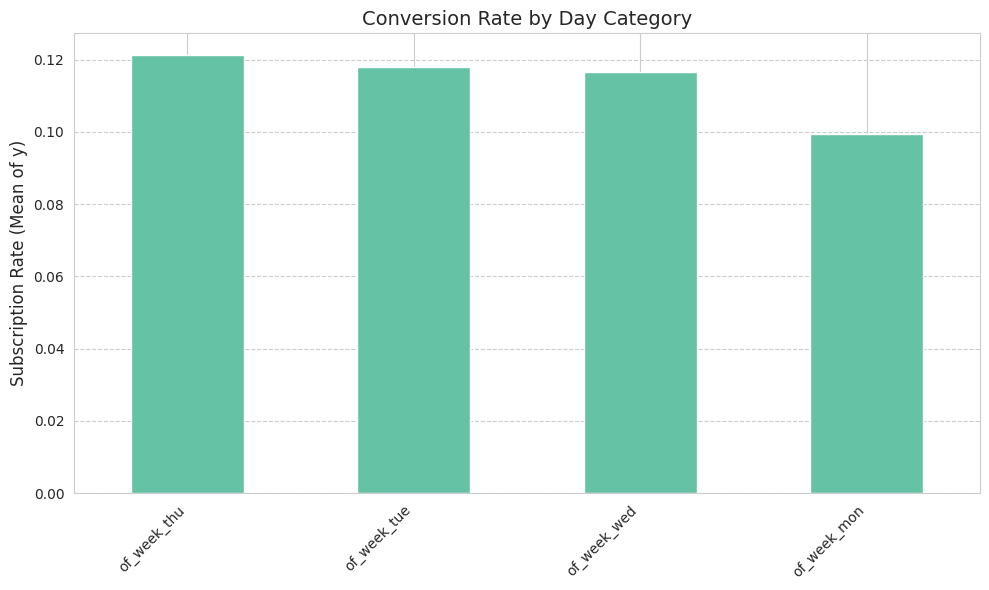


POUTCOME Conversion Rates (Top 5 for poutcome):
|             |      0 |
|:------------|-------:|
| success     | 0.6511 |
| nonexistent | 0.0883 |


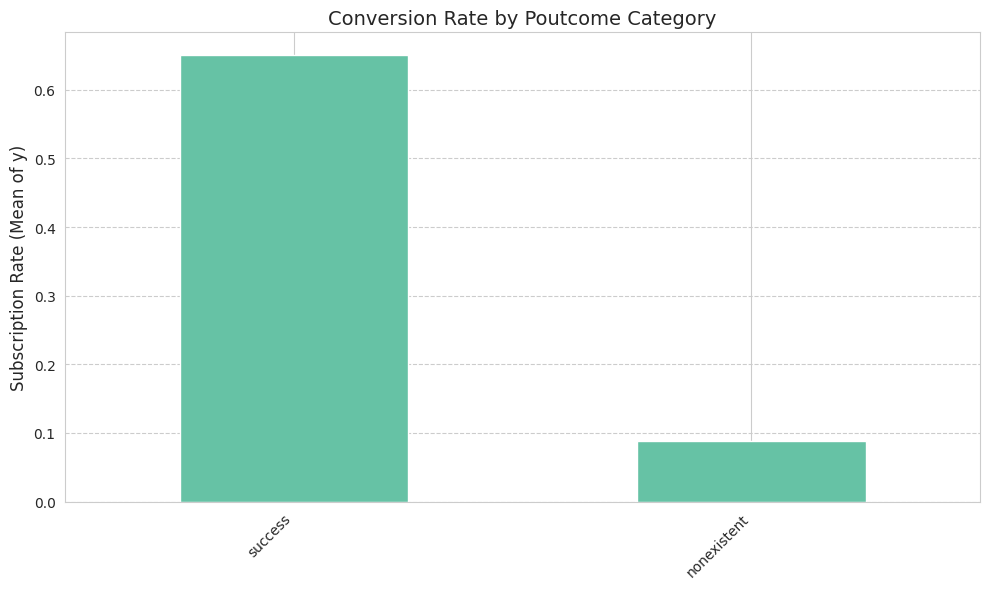

In [9]:
print("\n4) Categorical Feature Analysis and Propensity Rate")

#Identify boolean (one-hot encoded) columns
bool_cols = df.select_dtypes(include='bool').columns.tolist()

#Group columns by original feature (e.g., job_, marital_, etc.)
feature_groups = {}
for col in bool_cols:
    prefix = col.split('_')[0]
    if prefix not in feature_groups:
        feature_groups[prefix] = []
    feature_groups[prefix].append(col)

#Calculate and plot subscription rate (mean of 'y') for each category
top_n = 5
for prefix, cols in feature_groups.items():
    category_rates = {}
    for col in cols:
        #Calculate conversion rate (mean of y) where the one-hot column is True (1)
        rate = df.loc[df[col] == True, 'y'].mean()
        #Clean up column name for plot readability
        clean_col_name = col.replace(f'{prefix}_', '')
        category_rates[clean_col_name] = rate

    conversion_rates_series = pd.Series(category_rates).sort_values(ascending=False)
    #Print and Plot the Top 5
    print(f"\n{prefix.upper()} Conversion Rates (Top {top_n} for {prefix}):")
    print(conversion_rates_series.head(top_n).to_markdown(floatfmt=".4f"))

    plt.figure(figsize=(10, 6))
    conversion_rates_series.head(top_n).plot(kind='bar', color=sns.color_palette("Set2")[0])
    plt.title(f'Conversion Rate by {prefix.capitalize()} Category', fontsize=14)
    plt.ylabel('Subscription Rate (Mean of y)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig(f'{prefix}_conversion_rate.png')
    plt.show()

INSIGHTS (Expected):
poutcome_success will have the highest conversion rate, confirming its strong predictive power.

month_mar, month_sep, month_oct, and month_dec typically show much higher propensity rates due to campaign timing.

job_retired and job_student often show above-average propensity.

5) Correlation Analysis


5. Correlation Analysis

Correlation Matrix for Numerical Features:
|                |   age |   duration |   campaign |   pdays |   previous |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed |
|:---------------|------:|-----------:|-----------:|--------:|-----------:|---------------:|-----------------:|----------------:|------------:|--------------:|
| age            |  1.00 |      -0.00 |       0.00 |   -0.03 |       0.02 |          -0.00 |             0.00 |            0.13 |        0.01 |         -0.02 |
| duration       | -0.00 |       1.00 |      -0.07 |   -0.05 |       0.02 |          -0.03 |             0.01 |           -0.01 |       -0.03 |         -0.04 |
| campaign       |  0.00 |      -0.07 |       1.00 |    0.05 |      -0.08 |           0.15 |             0.13 |           -0.01 |        0.14 |          0.14 |
| pdays          | -0.03 |      -0.05 |       0.05 |    1.00 |      -0.59 |           0.27 |             0.08 |           -0.09 |  

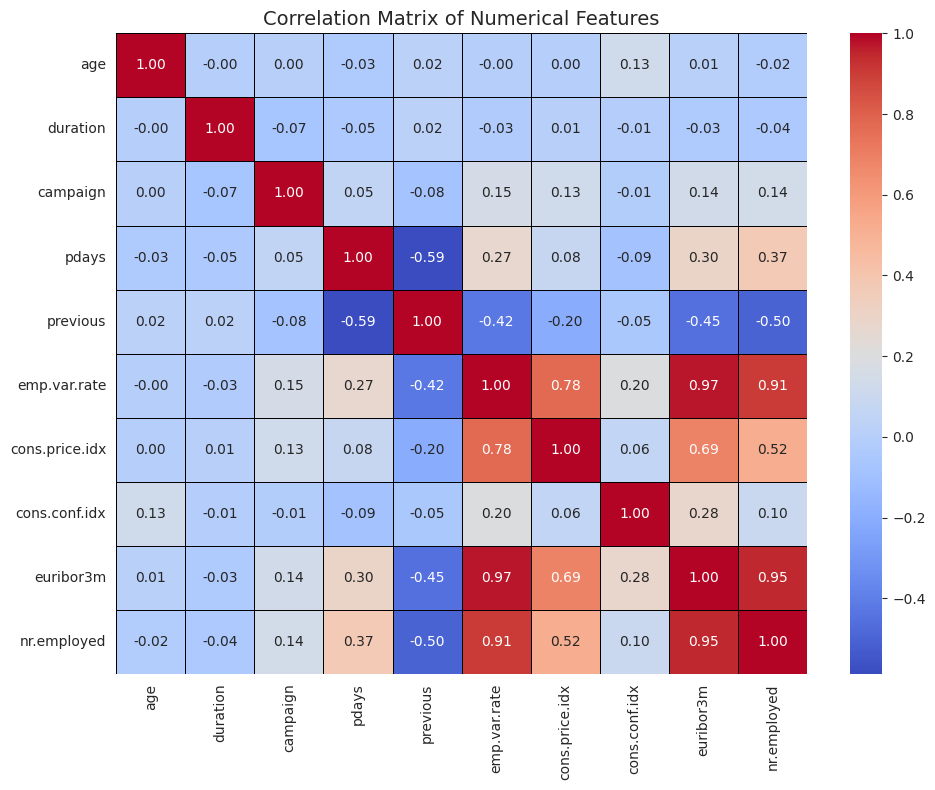

In [10]:
print("\n5. Correlation Analysis")
#Correlation Matrix for Numerical Features
corr_matrix = df[numerical_cols].corr()

print("\nCorrelation Matrix for Numerical Features:")
print(corr_matrix.to_markdown(floatfmt=".2f"))

#Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

INSIGHT: High correlation (multicollinearity) is expected among socio-economic variables (e.g., 'emp.var.rate', 'euribor3m', 'nr.employed'). For modeling, you should consider regularization or dropping one of the highly correlated features.